In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.integrate import quad
from scipy.integrate import simpson

In [19]:
b=  445 #GeV^-3
a = 42.7 #GeV^4
Nc = 3
g=4
lam =0.2 #GeV
mN = 0.938 #GeV/c**2
mQ = mN/Nc
rho0 = 1.23e-3  #GeV^3
c = g/(2 ** np.pi**2)

# -------------------- nucleon interactions ideal

def nN_id(kbu, kf, N=1000):
    k = np.linspace(kbu, kf, N)
    f = k**2
    c = g / (2 * np.pi**2)
    result = simpson(f, k)
    return c * result

def eN_id(kbu, kf, N=1000):
    k = np.linspace(kbu, kf, N)
    f = k**2 * np.sqrt(mN**2 + k**2)
    c = g / (2 * np.pi**2)
    result = simpson(f, k)
    return c * result





# ---------- QUARK CONTRIBUTIONS ----------
def nQ_id(kbu, N=1000):
    q = np.linspace(0, kbu / Nc, N)
    f = q * np.sqrt(lam**2 + q**2)
    c = g / (2 * np.pi**2)
    result = simpson(f, q)
    return c * result

def eQ_id(kbu, N=1000):
    q = np.linspace(0, kbu / Nc, N)
    f = q * np.sqrt(lam**2 + q**2) * np.sqrt(mQ**2 + q**2)
    c = Nc * g / (2 * np.pi**2)
    result = simpson(f, q)
    return c * result


# ---------- VAN DER WAALS CORRECTIONS ----------

def nN_vdw(kbu, kf, b=b):
    nN = nN_id(kbu, kf)
    return nN / (1 + b * nN)

def eN_vdw(kbu, kf, a=a, b=b):
    nN_corr = nN_vdw(kbu, kf, b)
    eN = eN_id(kbu, kf)
    return (1 - b * nN_corr) * eN - a * nN_corr**2


In [20]:
# nb = 2.5 * rho0
nb_list = np.linspace(0,5,100) * rho0
fq_min = []
kbu_list_min = []
kf_list_min = []
for nb in nb_list:
    fQ_min = max(0.0, 1.0 - 1.0/(b*nb) + 1e-6)
    fq = np.linspace(fQ_min, 1.0, 400)
    nq = nb * fq

    def kbu_from_nq(nq):
        term = lam**3 + (6*np.pi**2*nq)/g
        val  = term**(2/3) - lam**2
        return Nc * np.sqrt(np.maximum(val, 0.0))

    kbu_vals = kbu_from_nq(nq)

    def solve_kF(kbu, nb, nq, b=b):
        nN = nb - nq

        nN_id = nN/(1 - b*nN)
        val = kbu**3 + (6*np.pi**2/g)*nN_id
        return val**(1/3)

    kF_vals = np.array([solve_kF(KBU, nb, NQ) for KBU, NQ in zip(kbu_vals, nq)])
    # collect the energy density thorhg the pairs of kbu and kf at the minimum value selected of fQ
    epsilon_list = []
    for KBU, KF in zip(kbu_vals, kF_vals):
        epsilon_list.append(eN_vdw(KBU, KF, a=a, b=b) + eQ_id(KBU))

    epsilon = np.array(epsilon_list)
    mask = np.isfinite(epsilon)
    fq_phys = fq[mask]
    eps_phys = epsilon[mask] #remove the .nan

    i = np.argmin(eps_phys)
    # print("fq min", fQ_min)
    # print(f"Minimum energy density = {eps_phys[i]:.6e} at fQ = {fq_phys[i]:.3f}")
    fq_min.append(fq_phys[i])
    kbu_list_min.append(kbu_vals[i])
    kf_list_min.append(kF_vals[i])

/tmp/ipython-input-3811163268.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  fQ_min = max(0.0, 1.0 - 1.0/(b*nb) + 1e-6)


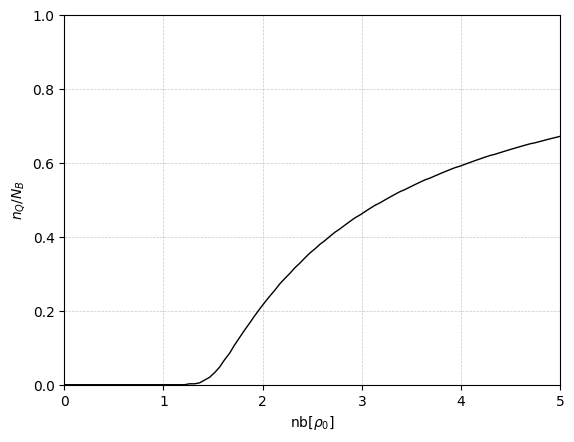

In [21]:
plt.plot(np.linspace(0,5,100),np.array(fq_min), lw=1, color='black')
plt.ylim(0,1)
plt.xlim(0,5)
plt.xlabel(r'nb[$\rho_0$]')
plt.ylabel(r'$n_Q/N_B$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})

plt.show()


 # reporuduce the next graph and then move to the next excluded volumes energy density ans pressure
# binding energy speed of sound
# euler eq to calculate pressure (it is in Tripp papers)
# November third tripp ll be free

In [22]:
energy_dens_vdw=[]
energy_dens_vdw_no_mn=[]
for e in range(len(kbu_list_min)):
    # plt.scatter(nb_list[e], (eN_vdw(kbu_list_min[e], kf_list_min[e], a=a, b=b) + eQ_id(kbu_list_min[e]))/nb_list[e]-mN, color='black')
    energy_dens_vdw.append((eN_vdw(kbu_list_min[e], kf_list_min[e], a=a, b=b) + eQ_id(kbu_list_min[e]))/nb_list[e]-mN)
    energy_dens_vdw_no_mn.append(eN_vdw(kbu_list_min[e], kf_list_min[e], a=a, b=b) + eQ_id(kbu_list_min[e]))

/tmp/ipython-input-3933265704.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  energy_dens_vdw.append((eN_vdw(kbu_list_min[e], kf_list_min[e], a=a, b=b) + eQ_id(kbu_list_min[e]))/nb_list[e]-mN)


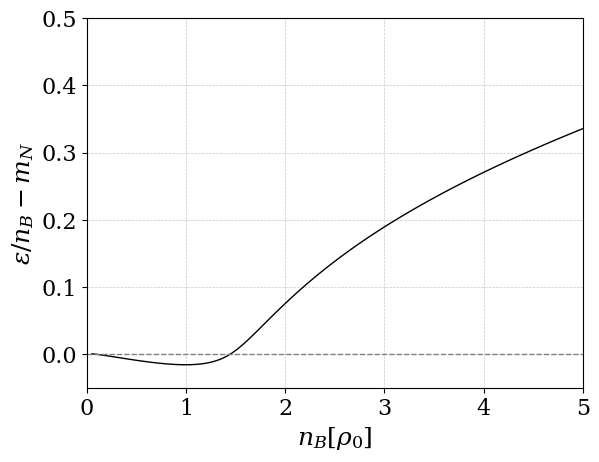

In [23]:
plt.plot(np.linspace(0,5,100), np.array(energy_dens_vdw), color='black', lw=1)
plt.ylim(-0.05, 0.5)
plt.xlim(0, 5)
plt.xlabel(r'$n_B[\rho_0]$')
plt.ylabel(r'$\epsilon / n_B - m_N$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})

plt.show()

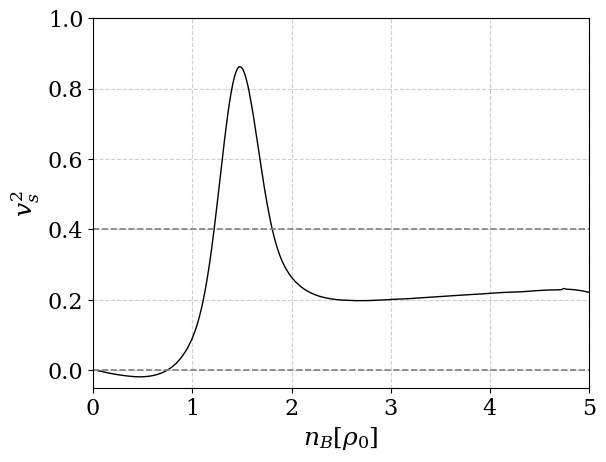

In [24]:
from scipy.signal import savgol_filter



nb = np.array(nb_list/rho0)
eps = np.array(energy_dens_vdw_no_mn)
order = np.argsort(nb)
nb, eps = nb[order], eps[order]
mask = nb > 0.0
nb, eps = nb[mask], eps[mask]
nB = np.linspace(nb.min(), nb.max(), 300)
epsilon = np.interp(nB, nb, eps)
deps_dn = np.gradient(epsilon, nB, edge_order=2)
P = nB * deps_dn - epsilon
dP_dn = np.gradient(P, nB, edge_order=2)
cs2 = dP_dn / deps_dn


epsilon_smooth = savgol_filter(epsilon, 31, 3)
deps_dn = np.gradient(epsilon_smooth, nB)
P = nB * deps_dn - epsilon_smooth
P_smooth = savgol_filter(P, 31, 3)
dP_dn = np.gradient(P_smooth, nB)
cs2_vm = dP_dn / deps_dn

plt.plot(nB, cs2_vm, color='black', lw=1)
plt.xlabel(r'$n_B[\rho_0]$')
plt.ylabel(r'$v_s^2$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.2)
plt.axhline(y=0.4, color='gray', linestyle='--', linewidth=1.2)


plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})
plt.xlim(0,5)
plt.ylim(-0.05, 1)
plt.show()


In [25]:
a = 45.03 # GeV^4
b = 576.41 # GeV^-3

Nc = 3
g=4
lam =0.2 #GeV
mN = 0.938 #GeV/c**2
mQ = mN/Nc
rho0 = 1.23e-3  #GeV^3
c = g/(2 ** np.pi**2)


# ---------- QUARK CONTRIBUTIONS ----------
def nQ_id(kbu, N=1000):
    q = np.linspace(0, kbu / Nc, N)
    f = q * np.sqrt(lam**2 + q**2)
    c = g / (2 * np.pi**2)
    result = simpson(f, q)
    return c * result

def eQ_id(kbu, N=1000):
    q = np.linspace(0, kbu / Nc, N)
    f = q * np.sqrt(lam**2 + q**2) * np.sqrt(mQ**2 + q**2)
    c = Nc * g / (2 * np.pi**2)
    result = simpson(f, q)
    return c * result

# ---------- VAN DER WAALS Carnahan-Starling   ----------


def fcs(b,nN):
    return np.exp(-(3*b*nN)/(4-b*nN)- (3*b*nN)/(4-b*nN)**2)


def nN_id(kbu, kf, N=1000):
    k = np.linspace(kbu, kf, N)
    f = k**2
    c = g / (2 * np.pi**2)
    result = simpson(f, k)
    return c * result

def eN_id(kbu, kf, N=1000):
    k = np.linspace(kbu, kf, N)
    f = k**2 * np.sqrt(mN**2 + k**2)
    c = g / (2 * np.pi**2)
    result = simpson(f, k)
    return c * result





In [26]:
nb_list = np.linspace(0, 5, 100) * rho0
fq_min_cs = []
kbu_list_min = []
kf_list_min = []
epsilon_CS = []
epsilon_cs_no_mn = []

def fcs(b, n):
    t = 4.0 - b*n
    return np.exp(-(3*b*n)/t - (4*b*n)/(t*t)) if t > 0 else np.inf

for nb in nb_list:

    # fQ_min = 0.0 if nb == 0 else max(0.0, 1.0 - 1.0/(b*nb) + 1e-6)
    # (If you want CS bound instead, use: max(0, (nb - 4.0/b)/nb + 1e-8) when nb>0)
    fQ_min = 0.0 if nb == 0 else max(0.0, (nb - 4.0/b)/nb + 1e-8)

    # handle degenerate case
    if fQ_min >= 1.0:
        continue

    fq = np.linspace(fQ_min, 1.0, 400)
    nq = nb * fq

    def kbu_from_nq(nq_vec):
        term = lam**3 + (6*np.pi**2*nq_vec)/g
        val  = term**(2/3) - lam**2
        return Nc * np.sqrt(np.maximum(val, 0.0))

    kbu_vals = kbu_from_nq(nq)

    def solve_kF(kbu, nb_s, nq_s, b=b):
        nN = nb_s - nq_s
        nN = min(nN, (4.0/b) - 1e-12)
        nN_id = nN / fcs(b, nN)
        val = kbu**3 + (6*np.pi**2/g)*nN_id
        return val**(1/3)

    kF_vals = np.array([solve_kF(KBU, nb, NQ) for KBU, NQ in zip(kbu_vals, nq)])

    def eNCS(KBU, KF, nb_s, nq_s, b=b, a=a):
        nN = nb_s - nq_s                 # <-- scalar
        nN = min(nN, (4.0/b) - 1e-12)
        # (kept your structure; if you later change physics, adjust here)
        return fcs(b, nN) * eN_id(KBU, KF, N=1000) - a * nN**2


    epsilon_list = [eNCS(KBU, KF, nb, NQ) + eQ_id(KBU)
                    for KBU, KF, NQ in zip(kbu_vals, kF_vals, nq)]

    epsilon = np.asarray(epsilon_list, dtype=float)  # ensure 1-D float array
    mask = np.isfinite(epsilon)
    if not np.any(mask):
        continue

    fq_phys = fq[mask]
    eps_phys = epsilon[mask]


    i = np.argmin(eps_phys)

    fq_min_cs.append(fq_phys[i])

    kbu_list_min.append(kbu_vals[mask][i])

    kf_list_min.append(kF_vals[mask][i])

    epsilon_CS.append(eps_phys[i]/nb-mN)
    epsilon_cs_no_mn.append(eps_phys[i])

/tmp/ipython-input-1771400075.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  epsilon_CS.append(eps_phys[i]/nb-mN)


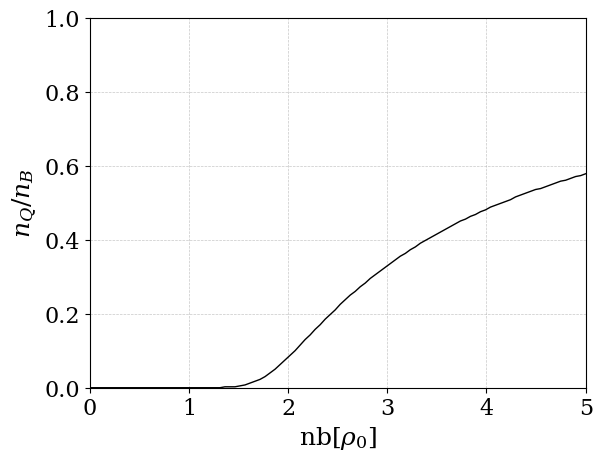

In [27]:
plt.plot(np.linspace(0,5,100),np.array(fq_min_cs), lw=1, color='black')
plt.ylim(0,1)
plt.xlim(0,5)
plt.xlabel(r'nb[$\rho_0$]')
plt.ylabel(r'$n_Q/n_B$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})

plt.show()


 # reporuduce the next graph and then move to the next excluded volumes energy density ans pressure
# binding energy speed of sound
# euler eq to calculate pressure (it is in Tripp papers)
# November third tripp ll be free

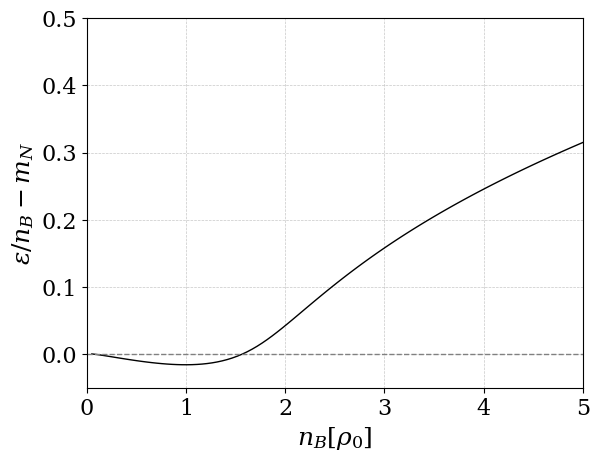

In [28]:
plt.plot(np.linspace(0,5,100), np.array(epsilon_CS), color='black', lw=1)
plt.ylim(-0.05, 0.5)
plt.xlim(0, 5)
plt.xlabel(r'$n_B[\rho_0]$')
plt.ylabel(r'$\epsilon / n_B - m_N$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})

plt.show()

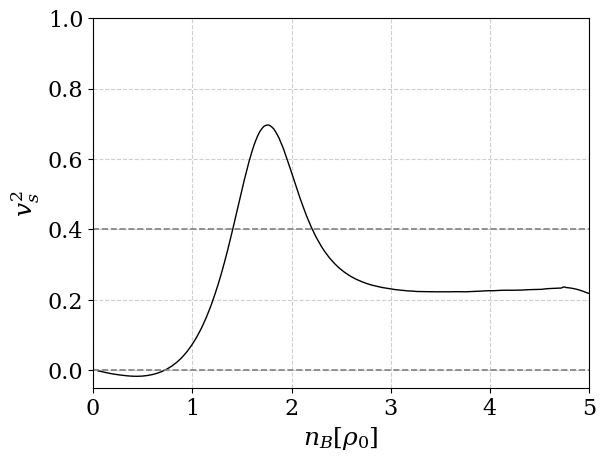

In [29]:
from scipy.signal import savgol_filter



nb = np.array(nb_list/rho0)
eps = np.array(epsilon_cs_no_mn)
order = np.argsort(nb)
nb, eps = nb[order], eps[order]
mask = nb > 0.0
nb, eps = nb[mask], eps[mask]
nB = np.linspace(nb.min(), nb.max(), 300)
epsilon = np.interp(nB, nb, eps)
deps_dn = np.gradient(epsilon, nB, edge_order=2)
P = nB * deps_dn - epsilon
dP_dn = np.gradient(P, nB, edge_order=2)
cs2 = dP_dn / deps_dn


epsilon_smooth = savgol_filter(epsilon, 31, 3)
deps_dn = np.gradient(epsilon_smooth, nB)
P = nB * deps_dn - epsilon_smooth
P_smooth = savgol_filter(P, 31, 3)
dP_dn = np.gradient(P_smooth, nB)
cs2_cs = dP_dn / deps_dn


plt.plot(nB, cs2_cs, color='black', lw=1)
plt.xlabel(r'$n_B[\rho_0]$')
plt.ylabel(r'$v_s^2$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.2)
plt.axhline(y=0.4, color='gray', linestyle='--', linewidth=1.2)


plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})
plt.xlim(0,5)
plt.ylim(-0.05, 1)
plt.show()


In [30]:
a = 45.28 # GeV^4
b = 556.89 # GeV^-3
# ----------  VAN DER WAALS trivirial model (TVM)   ----------
def ftvm(b, nN):
  return np.exp(-b*nN - (b *nN)**2/(2))

In [31]:
nb_list = np.linspace(0, 5, 100) * rho0
fq_min_tvm = []
kbu_list_min = []
kf_list_min = []
epsilon_tvm = []
epsilon_tvm_no_mn = []

def fcs(b, n):
    t = 4.0 - b*n
    return np.exp(-(3*b*n)/t - (4*b*n)/(t*t)) if t > 0 else np.inf

for nb in nb_list:

    # fQ_min = 0.0 if nb == 0 else max(0.0, 1.0 - 1.0/(b*nb) + 1e-6)
    # (If you want CS bound instead, use: max(0, (nb - 4.0/b)/nb + 1e-8) when nb>0)
    fQ_min = 0.0 if nb == 0 else max(0.0, (nb - 4.0/b)/nb + 1e-8)

    # handle degenerate case
    if fQ_min >= 1.0:
        continue

    fq = np.linspace(fQ_min, 1.0, 400)
    nq = nb * fq

    def kbu_from_nq(nq_vec):
        term = lam**3 + (6*np.pi**2*nq_vec)/g
        val  = term**(2/3) - lam**2
        return Nc * np.sqrt(np.maximum(val, 0.0))

    kbu_vals = kbu_from_nq(nq)

    def solve_kF(kbu, nb_s, nq_s, b=b):
        nN = nb_s - nq_s
        nN = min(nN, (4.0/b) - 1e-12)
        nN_id = nN / fcs(b, nN)
        val = kbu**3 + (6*np.pi**2/g)*nN_id
        return val**(1/3)

    kF_vals = np.array([solve_kF(KBU, nb, NQ) for KBU, NQ in zip(kbu_vals, nq)])

    def eNTVM(KBU, KF, nb_s, nq_s, b=b, a=a):
        nN = nb_s - nq_s                 # <-- scalar
        nN = min(nN, (4.0/b) - 1e-12)
        # (kept your structure; if you later change physics, adjust here)
        return fcs(b, nN) * eN_id(KBU, KF, N=1000) - a * nN**2


    epsilon_list = [eNTVM(KBU, KF, nb, NQ, b=b, a=a) + eQ_id(KBU)
                    for KBU, KF, NQ in zip(kbu_vals, kF_vals, nq)] #eNCS(KBU, KF, nb, NQ)

    epsilon = np.asarray(epsilon_list, dtype=float)  # ensure 1-D float array
    mask = np.isfinite(epsilon)
    if not np.any(mask):
        continue

    fq_phys = fq[mask]
    eps_phys = epsilon[mask]


    i = np.argmin(eps_phys)

    fq_min_tvm.append(fq_phys[i])

    kbu_list_min.append(kbu_vals[mask][i])

    kf_list_min.append(kF_vals[mask][i])

    epsilon_tvm.append(eps_phys[i]/nb-mN)
    epsilon_tvm_no_mn.append(eps_phys[i])

/tmp/ipython-input-4073480400.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  epsilon_tvm.append(eps_phys[i]/nb-mN)


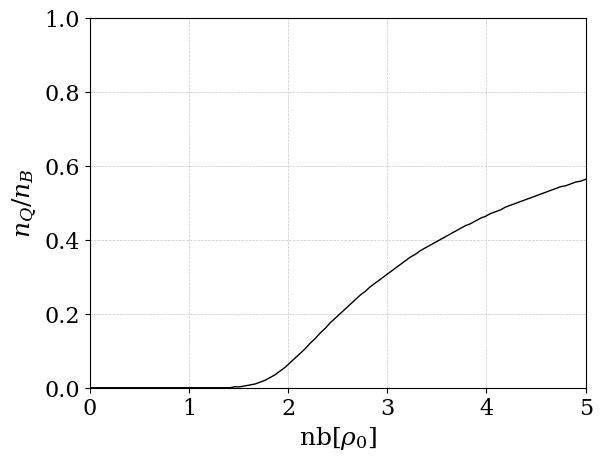

In [32]:
plt.plot(np.linspace(0,5,100),np.array(fq_min_tvm), lw=1, color='black')
plt.ylim(0,1)
plt.xlim(0,5)
plt.xlabel(r'nb[$\rho_0$]')
plt.ylabel(r'$n_Q/n_B$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})

plt.show()


 # reporuduce the next graph and then move to the next excluded volumes energy density ans pressure
# binding energy speed of sound
# euler eq to calculate pressure (it is in Tripp papers)
# November third tripp ll be free

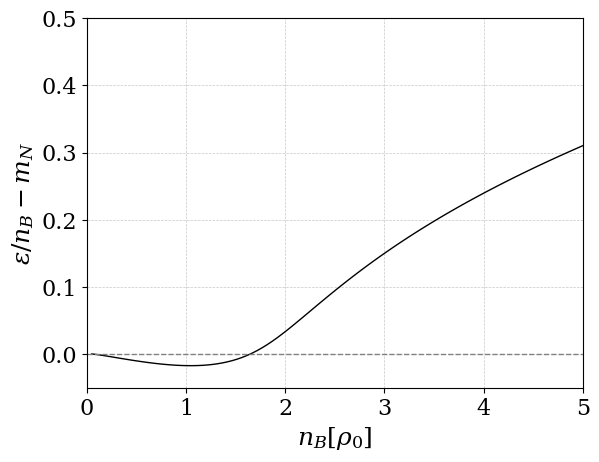

In [33]:
plt.plot(np.linspace(0,5,100), np.array(epsilon_tvm), color='black', lw=1)
plt.ylim(-0.05, 0.5)
plt.xlim(0, 5)
plt.xlabel(r'$n_B[\rho_0]$')
plt.ylabel(r'$\epsilon / n_B - m_N$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})

plt.show()

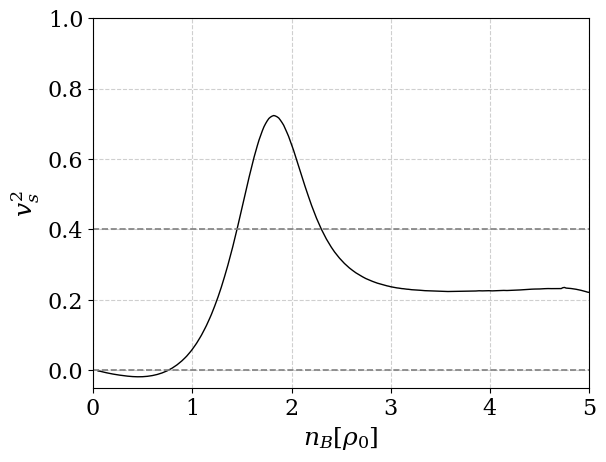

In [34]:
from scipy.signal import savgol_filter



nb = np.array(nb_list/rho0)
eps = np.array(epsilon_tvm_no_mn)
order = np.argsort(nb)
nb, eps = nb[order], eps[order]
mask = nb > 0.0
nb, eps = nb[mask], eps[mask]
nB = np.linspace(nb.min(), nb.max(), 300)
epsilon = np.interp(nB, nb, eps)
deps_dn = np.gradient(epsilon, nB, edge_order=2)
P = nB * deps_dn - epsilon
dP_dn = np.gradient(P, nB, edge_order=2)
cs2 = dP_dn / deps_dn


epsilon_smooth = savgol_filter(epsilon, 31, 3)
deps_dn = np.gradient(epsilon_smooth, nB)
P = nB * deps_dn - epsilon_smooth
P_smooth = savgol_filter(P, 31, 3)
dP_dn = np.gradient(P_smooth, nB)
cs2 = dP_dn / deps_dn


plt.plot(nB, cs2, color='black', lw=1)
plt.xlabel(r'$n_B[\rho_0]$')
plt.ylabel(r'$v_s^2$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.2)
plt.axhline(y=0.4, color='gray', linestyle='--', linewidth=1.2)


plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})
plt.xlim(0,5)
plt.ylim(-0.05, 1)
plt.show()


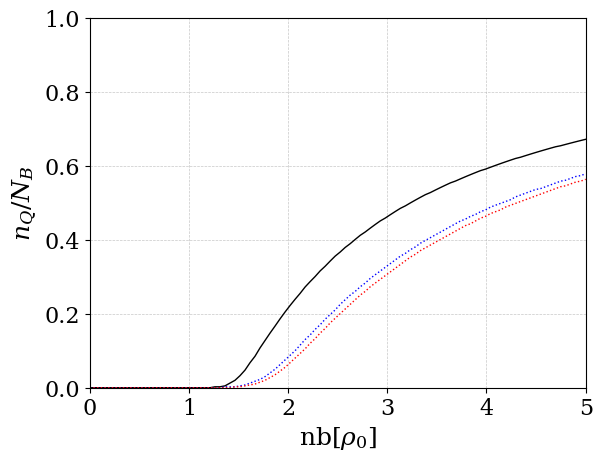

In [39]:
plt.plot(np.linspace(0,5,100),np.array(fq_min), lw=1, color='black')
plt.plot(np.linspace(0,5,100),np.array(fq_min_cs), lw=1, color='blue', linestyle=':')
plt.plot(np.linspace(0,5,100),np.array(fq_min_tvm), lw=1, color='red', linestyle=':')

plt.ylim(0,1)
plt.xlim(0,5)
plt.xlabel(r'nb[$\rho_0$]')
plt.ylabel(r'$n_Q/N_B$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})

plt.show()


 # reporuduce the next graph and then move to the next excluded volumes energy density ans pressure
# binding energy speed of sound
# euler eq to calculate pressure (it is in Tripp papers)
# November third tripp ll be free

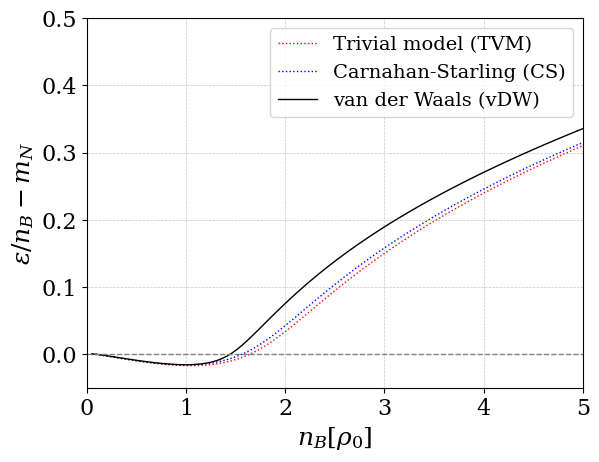

In [43]:
plt.plot(np.linspace(0,5,100), np.array(epsilon_tvm), color='red', lw=1, linestyle=':',label ='Trivial model (TVM)')
plt.plot(np.linspace(0,5,100), np.array(epsilon_CS), color='blue', lw=1,  linestyle=':',label='Carnahan-Starling (CS)')
plt.plot(np.linspace(0,5,100), np.array(energy_dens_vdw), color='black', lw=1,label='van der Waals (vDW)')

plt.ylim(-0.05, 0.5)
plt.xlim(0, 5)
plt.xlabel(r'$n_B[\rho_0]$')
plt.ylabel(r'$\epsilon / n_B - m_N$')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})
plt.legend()
plt.show()

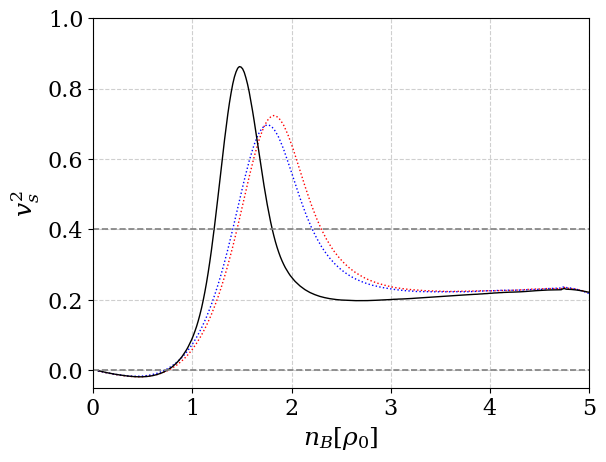

In [42]:
from scipy.signal import savgol_filter



nb = np.array(nb_list/rho0)
eps = np.array(epsilon_tvm_no_mn)
order = np.argsort(nb)
nb, eps = nb[order], eps[order]
mask = nb > 0.0
nb, eps = nb[mask], eps[mask]
nB = np.linspace(nb.min(), nb.max(), 300)
epsilon = np.interp(nB, nb, eps)
deps_dn = np.gradient(epsilon, nB, edge_order=2)
P = nB * deps_dn - epsilon
dP_dn = np.gradient(P, nB, edge_order=2)
cs2 = dP_dn / deps_dn


epsilon_smooth = savgol_filter(epsilon, 31, 3)
deps_dn = np.gradient(epsilon_smooth, nB)
P = nB * deps_dn - epsilon_smooth
P_smooth = savgol_filter(P, 31, 3)
dP_dn = np.gradient(P_smooth, nB)
cs2_tvm = dP_dn / deps_dn


plt.plot(nB, cs2_tvm, color='red', lw=1, linestyle=':')
plt.plot(nB, cs2_cs, color='blue', lw=1, linestyle=':')
plt.plot(nB, cs2_vm, color='black', lw=1)

plt.xlabel(r'$n_B[\rho_0]$')
plt.ylabel(r'$v_s^2$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.2)
plt.axhline(y=0.4, color='gray', linestyle='--', linewidth=1.2)


plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})
plt.xlim(0,5)
plt.ylim(-0.05, 1)
plt.show()
